In [10]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def load_netflix_ratings(file_path, sample_size=10000):
    """
    Load and sample Netflix ratings data from combined_data txt file.
    Returns DataFrame with Cust_Id, Rating, and Movie_Id columns.
    """
    # Read the file line by line to properly handle movie IDs
    movie_id = None
    data = []
    
    with open(file_path, 'r') as f:
        lines = f.readlines()
        # Take a random sample of lines to reduce data size
        sampled_lines = np.random.choice(lines, min(sample_size, len(lines)), replace=False)
        
        for line in sampled_lines:
            line = line.strip()
            if line.endswith(':'):
                movie_id = line.replace(':', '')
            else:
                # Skip empty lines
                if not line:
                    continue
                cust_id, rating, *_ = line.split(',')
                data.append({
                    'Cust_Id': cust_id,
                    'Rating': float(rating),
                    'Movie_Id': movie_id
                })
    
    # Create DataFrame
    df = pd.DataFrame(data)
    return df

def plot_rating_distribution(df):
    """
    Create a horizontal bar plot showing rating distribution.
    """
    plt.figure(figsize=(12, 6))
    
    # Calculate rating distribution
    rating_dist = df.groupby('Rating')['Rating'].agg(['count'])
    
    # Plot horizontal bars
    ax = rating_dist.plot(kind='barh', legend=False)
    
    # Add title with summary statistics
    movie_count = df['Movie_Id'].nunique()
    cust_count = df['Cust_Id'].nunique()
    rating_count = len(df)
    
    plt.title(f'Total pool: {movie_count:,} Movies, {cust_count:,} customers, {rating_count:,} ratings given',
              fontsize=12)
    
    # Add percentage labels on bars
    for i in range(1, 6):
        percentage = rating_dist.iloc[i-1][0] * 100 / rating_dist.sum()[0]
        ax.text(rating_dist.iloc[i-1][0]/4, i-1, 
                f'Rating {i}: {percentage:.1f}%',
                color='white', weight='bold')
    
    plt.tight_layout()
    return plt



In [24]:
# Load and sample data
file_path = 'archive/combined_data_1.txt'
sample_size = 50000  # Adjust this value to control dataset size

print(f"Loading data with sample size: {sample_size}")
df = load_netflix_ratings(file_path, sample_size)

# Print basic statistics
print('\nDataset shape:', df.shape)
print('\nDataset examples:')
print(df.head())



Loading data with sample size: 50000

Dataset shape: (49996, 3)

Dataset examples:
   Cust_Id  Rating Movie_Id
0   686510     5.0     None
1  2640129     4.0     None
2   195058     5.0     None
3  1837730     2.0     None
4  1757417     3.0     None


/var/folders/87/dhv__9sj0yv1kz0pfv2ds9nh0000gn/T/ipykernel_11811/2085622049.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percentage = rating_dist.iloc[i-1][0] * 100 / rating_dist.sum()[0]
/var/folders/87/dhv__9sj0yv1kz0pfv2ds9nh0000gn/T/ipykernel_11811/2085622049.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(rating_dist.iloc[i-1][0]/4, i-1,


<Figure size 1200x600 with 0 Axes>

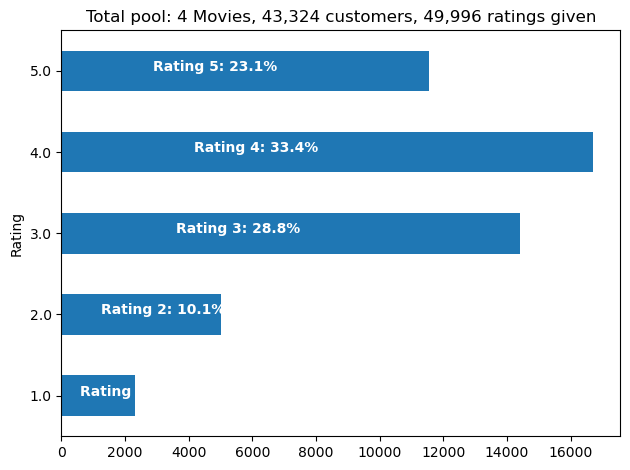

In [25]:
# Create and show plot
plot_rating_distribution(df)
plt.show()


In [26]:
import pandas as pd
import numpy as np
from surprise import Reader, Dataset, SVD, KNNBasic, NMF
from surprise.model_selection import cross_validate

def prepare_data(df, min_reviews_quantile=0.7):
    """
    Prepare data by filtering out movies and customers with too few reviews
    """
    # Calculate review count summaries
    f = ['count', 'mean']
    df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
    df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
    
    # Convert indices to int
    df_movie_summary.index = df_movie_summary.index.map(int)
    df_cust_summary.index = df_cust_summary.index.map(int)
    
    # Calculate benchmarks
    movie_benchmark = round(df_movie_summary['count'].quantile(min_reviews_quantile), 0)
    cust_benchmark = round(df_cust_summary['count'].quantile(min_reviews_quantile), 0)
    
    # Get lists of movies and customers to drop
    drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index
    drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index
    
    print(f'Movie minimum times of review: {movie_benchmark}')
    print(f'Customer minimum times of review: {cust_benchmark}')
    print(f'Original Shape: {df.shape}')
    
    # Filter the dataframe
    df_filtered = df[~df['Movie_Id'].isin(drop_movie_list)]
    df_filtered = df_filtered[~df_filtered['Cust_Id'].isin(drop_cust_list)]
    
    print(f'After Trim Shape: {df_filtered.shape}')
    return df_filtered

def read_movie_titles(file_path):
    """
    Read and parse movie titles file
    """
    data = []
    with open(file_path, encoding="latin1") as file:
        for line in file:
            parts = line.strip().split(',', 2)
            if len(parts) == 3:
                movie_id, year, name = parts
                data.append([movie_id, year, name])
            else:
                print(f"Skipping malformed line: {line.strip()}")
    
    return pd.DataFrame(data, columns=['Movie_Id', 'Year', 'Name'])

def train_recommendation_models(df):
    """
    Train multiple recommendation algorithms
    """
    # Initialize algorithms
    algorithms = {
        "SVD": SVD(n_epochs=5),  # Reduced epochs for faster training
        "KNN": KNNBasic(k=20),   # Reduced neighbors for faster computation
        "NMF": NMF(n_epochs=5)   # Reduced epochs for faster training
    }
    
    # Prepare data for Surprise library
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)
    trainset = data.build_full_trainset()
    
    # Train models
    trained_models = {}
    for name, algo in algorithms.items():
        print(f"Training {name}...")
        trained_models[name] = algo.fit(trainset)
    
    return trained_models

def get_recommendations(user_id, df, df_title, trained_models, top_n=10):
    """
    Get movie recommendations for a specific user
    """
    # Remove movies the user has already rated
    rated_movies = df[df['Cust_Id'] == user_id]['Movie_Id']
    user_recommendations = df_title[~df_title['Movie_Id'].isin(rated_movies)].copy()
    
    # Function to get average prediction score
    def get_average_score(movie_id):
        scores = []
        for algo in trained_models.values():
            try:
                pred = algo.predict(str(user_id), str(movie_id))
                scores.append(pred.est)
            except Exception as e:
                print(f"Error predicting for movie {movie_id}: {e}")
                continue
        return np.mean(scores) if scores else 0
    
    # Get predictions for each movie
    print("Generating predictions...")
    user_recommendations['Estimate_Score'] = user_recommendations['Movie_Id'].apply(get_average_score)
    
    # Sort and return top recommendations
    return user_recommendations.sort_values('Estimate_Score', ascending=False).head(top_n)


In [27]:
# Prepare the data
df_filtered = prepare_data(df)

# Load movie titles
df_title = read_movie_titles('archive/movie_titles.csv')
print("\nMovie titles loaded:", len(df_title))

# Train models
trained_models = train_recommendation_models(df_filtered)

# Get recommendations for a sample user
sample_user_id = df_filtered['Cust_Id'].iloc[0]  # Take first user as example
recommendations = get_recommendations(sample_user_id, df_filtered, df_title, trained_models)

print(f"\nTop 10 recommendations for user {sample_user_id}:")
print(recommendations[['Year', 'Name', 'Estimate_Score']])


Movie minimum times of review: 14573.0
Customer minimum times of review: 1.0
Original Shape: (49996, 3)
After Trim Shape: (49996, 3)

Movie titles loaded: 17770
Training SVD...
Training KNN...
Computing the msd similarity matrix...
Done computing similarity matrix.
Training NMF...
Generating predictions...

Top 10 recommendations for user 686510:
       Year                                     Name  Estimate_Score
1981   2001                        Strange Frequency        3.756372
3449   2003                WWE: Survivor Series 2004        3.736194
1644   2003                              The In-Laws        3.728790
11838  2000                               Mark Twain        3.616225
11851  1991                Return to the Blue Lagoon        3.616225
11850  1946                             The Yearling        3.616225
11849  2003  Dumb and Dumberer: When Harry Met Lloyd        3.616225
11848  1998                                    Earth        3.616225
11847  1997                   